# Interpretabilidad del modelo 9M

## Imports y funciones del modelo

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
valor = os.getenv("XLA_PYTHON_CLIENT_PREALLOCATE")
print(valor)

if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

false


In [2]:
import importlib

import chess
import chess.svg
from IPython.display import SVG, display

from jax import random as jrandom
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib import gridspec
import pickle
import json
import gc
import random

import networkx as nx
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

#os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")

In [3]:
from searchless_chess.src import transformer_xai
importlib.reload(transformer_xai)
from searchless_chess.src import tokenizer
from searchless_chess.src import training_utils
from searchless_chess.src import utils
from searchless_chess.src.engines import engine
from searchless_chess.src.engines import neural_engines
import searchless_chess.src.engines.constants as constants

Failed to import GCSFileSystem; loading of this filesystem will be skipped. Error details: cannot import name 'storage' from 'google.cloud' (unknown location)


In [ ]:
# @title Create the predictor (9M)
policy = 'action_value'
num_return_buckets = 128
num_heads = 8
num_layers = 8
embedding_dim = 256

output_size = num_return_buckets
predictor_config = transformer_xai.TransformerConfig(
    vocab_size=utils.NUM_ACTIONS,
    output_size=output_size,
    pos_encodings=transformer_xai.PositionalEncodings.LEARNED,
    max_sequence_length=tokenizer.SEQUENCE_LENGTH + 2,
    num_heads=num_heads,
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    apply_post_ln=True,
    apply_qk_layernorm=False,
    use_causal_mask=False,
)

predictor = transformer_xai.build_transformer_predictor(config=predictor_config)

In [5]:
# @title Load the predictor parameters
os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")
checkpoint_dir = os.path.join(
    os.getcwd(),
    f'searchless_chess/checkpoints/9M',
)
dummy_params = predictor.initial_params(
    rng=jrandom.PRNGKey(6400000),
    targets=np.zeros((1, 1), dtype=np.uint32),
)
params = training_utils.load_parameters(
    checkpoint_dir=checkpoint_dir,
    params=dummy_params,
    use_ema_params=True,
    step=-1,
)

In [6]:
# @title Create the engine
batch_size = 1
jitted_predict_fn = jax.jit(predictor.predict)

def fixed_predict_fn(sequences: np.ndarray) -> np.ndarray:
    """Wrapper around the predictor `predict` function."""
    assert sequences.shape[0] == batch_size
    return jitted_predict_fn(
        params=params,
        targets=sequences,
        rng=None,
    )

def predict_fn(sequences: np.ndarray) -> np.ndarray:
    """Wrapper to collate batches of sequences of fixed size."""
    remainder = -len(sequences) % batch_size
    padded = np.pad(sequences, ((0, remainder), (0, 0)))
    sequences_split = np.split(padded, len(padded) // batch_size)
    all_outputs = []
    for sub_sequences in sequences_split:
        all_outputs.append(fixed_predict_fn(sub_sequences))
    print('sequences.shape[0]:', sequences.shape[0])
    return all_outputs[: (sequences.shape[0])] #outputs[: len(sequences)]  # Crop the padded sequences.


_, return_buckets_values = utils.get_uniform_buckets_edges_values(
    num_return_buckets
)

In [7]:
# Comprobamos que estemos utilizando JAX con GPU
print(jax.devices())

[CudaDevice(id=0)]


# Parámetros del modelo

In [ ]:
print('Parametros de 9M:')
print(params.keys())
print('embed:')
print(params['embed'].keys())
print(params['embed']['embeddings'].shape)
print('embed posicional:')
print(params['embed_1'].keys())
print(params['embed_1']['embeddings'].shape)
print('layer_norm:')
print(params['layer_norm'].keys())
print(params['layer_norm']['offset'].shape)
print(params['layer_norm']['scale'].shape)
print('linear:')
print(params['linear'].keys())
print(params['linear']['w'].shape)
print('multi_head_dot_product_attention/linear')
print(params['multi_head_dot_product_attention/linear'].keys())
print(params['multi_head_dot_product_attention/linear']['w'].shape)

### Embeddings

#### Posicional

In [ ]:
pos_labels = ['<start>', '<turn>', 
            'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
            'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
            'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
            'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
            'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
            'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
            'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
            'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
            '<castling_1>', '<castling_2>', '<castling_3>', '<castling_4>',
            '<en_passant_letter>','<en_passant_number>',
            '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
            '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
            'move']
len(pos_labels)

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(params['embed_1']['embeddings'], aspect='auto', cmap='viridis') 
plt.colorbar(label='Valor')
plt.title('Embedding posicional de la entrada')
plt.xlabel('Embedding')
plt.ylabel('Posiciones')

yticks = np.arange(len(pos_labels))
yticklabels = pos_labels
plt.yticks(ticks=yticks, labels=yticklabels)

plt.tight_layout()
plt.show()

In [ ]:
# Calcular la distancia entre los embeddings de cada token

data = params['embed_1']['embeddings']
distances_pos_embedding = np.zeros((data.shape[0], data.shape[0]))

for i in range(data.shape[0]):
    if i % 10 == 0:
        print(i)
    for j in range(i+1, data.shape[0]):
        distances_pos_embedding[i,j] = np.linalg.norm(data[i] - data[j])
        
for i in range(data.shape[0]):
    for j in range(i+1):
        distances_pos_embedding[i,j] = distances_pos_embedding[j,i]
#np.save('distances_between_pos_embeddings.npy', distances_pos_embedding)

In [ ]:
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances_pos_embedding, aspect='auto', cmap='viridis')  
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de posición')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

yticks = np.arange(len(pos_labels))
yticklabels = pos_labels
plt.yticks(ticks=yticks, labels=yticklabels)

plt.tight_layout()
plt.show()

In [ ]:
pos_ini = 2
pos_fin = 66
distancias_tablero = distances_pos_embedding[pos_ini:pos_fin,pos_ini:pos_fin]

# Crear figura con 8x8 subplots
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

# Iterar sobre cada bloque 8x8
for i in range(8):
    for j in range(8):
        pos_actual = i*8 + j
        block = distancias_tablero[i*8 + j].reshape(8, 8)
        ax = axes[i, j]
        im = ax.imshow(block, cmap='viridis')
        ax.axis('off')
        

plt.tight_layout()
plt.show()

#### Vocabulario

In [ ]:
# Creamos un diccionario para saber qué significa cada token
from collections import defaultdict

y_labels_dict = defaultdict(list)

for i in range(len(utils.ACTION_TO_MOVE.items())):
    y_labels_dict[i] = [str(i)]
    
# Mezclamos el primer diccionario
for v, k in tokenizer._CHARACTERS_INDEX.items():
    y_labels_dict[k].append(v)
    
# Mezclamos el segundo diccionario (invertido del tokenizer)
for k, v in utils.ACTION_TO_MOVE.items():
    y_labels_dict[k].append(v)

# Convertimos de nuevo a un diccionario normal (opcional)
y_labels_dict = {k: '/'.join(v) for k, v in y_labels_dict.items()}

print(y_labels_dict)

In [ ]:
# Graficamos los embeddings de los tokens
num_rows = 50

plt.figure(figsize=(12, 12))
plt.imshow(params['embed']['embeddings'][:num_rows, :], aspect='auto', cmap='viridis')
plt.colorbar(label='Valor')
plt.title('Embedding del vocabulario')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas al eje Y
yticks = list(y_labels_dict.keys())[:num_rows]
yticklabels = list(y_labels_dict.values())[:num_rows]
plt.yticks(ticks=yticks, labels=yticklabels)

plt.tight_layout()
plt.show()

In [ ]:
# Crear un array de ejemplo de tamaño 79x256
data = params['embed']['embeddings'][:256,:]

# Crear el mapa de calor
plt.figure(figsize=(12, 12))
plt.imshow(data, aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Embedding del vocabulario')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.tight_layout()
plt.show()

In [ ]:
# IDEA: Extraer solo embeddings de piezas o posiciones y ver si tienen características en común
# En qué se diferencian los embeddings de la misma pieza según el color?

In [ ]:
print(params['embed']['embeddings'].shape)

In [ ]:
# Calcular la distancia entre los embeddings de cada token
"""
data = params['embed']['embeddings']
distances = np.zeros((data.shape[0], data.shape[0]))

for i in range(data.shape[0]):
    if i % 10 == 0:
        print(i)
    for j in range(i+1, data.shape[0]):
        distances[i,j] = np.linalg.norm(data[i] - data[j])
        
for i in range(data.shape[0]):
    for j in range(i+1):
        distances[i,j] = distances[j,i]
np.save('distances_between_token_embeddings.npy', distances)
"""

In [ ]:
distances = np.load('distances_between_token_embeddings.npy')
distances.shape

In [ ]:
# Seleccionamos las posiciones donde estan las piezas
pos_b = 11
pos_ini_piezas = 19
pos_fin_piezas = 29
pos_point = 30

is_pieza = np.zeros((distances.shape[0],), dtype=bool)
is_pieza[pos_b] = 1
is_pieza[pos_ini_piezas:pos_fin_piezas] = 1
is_pieza[pos_point] = 1
print(is_pieza)

distances_piezas = distances[np.ix_(is_pieza, is_pieza)]


# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances_piezas, aspect='auto', cmap='viridis') 
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticklabels = [y_labels_dict[k] for k in np.argwhere(is_pieza == 1).flatten()]
ticks = np.arange(len(ticklabels))
print(ticklabels)
plt.xticks(ticks=ticks, labels=ticklabels, rotation=90)
plt.yticks(ticks=ticks, labels=ticklabels)

plt.tight_layout()
plt.show()

In [ ]:
fila_inicial = 0
fila_final = 50
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(12, 12))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de diferente tipo')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels, rotation=90)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
for items in utils.MOVE_TO_ACTION.items():
    print(items[0], items[1])

In [ ]:
fila_inicial = 0
fila_final = 400
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(35, 35))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels, rotation=90)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
fila_inicial = 739
fila_final = 842
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(20, 20))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels, rotation=90)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(30, 30))
plt.imshow(distances, aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')


plt.tight_layout()
plt.show()

In [ ]:
fila_inicial = 1792
fila_final = 1967
# Crear el mapa de calor con las distancias entre embeddings
plt.figure(figsize=(24, 24))
plt.imshow(distances[fila_inicial:fila_final,fila_inicial:fila_final], aspect='auto', cmap='viridis')  # Puedes usar otros cmap como 'plasma', 'hot', 'coolwarm'
plt.colorbar(label='Valor')
plt.title('Distancias entre embeddings de piezas')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Asignar etiquetas a los ejes
ticks = list(range(fila_final-fila_inicial))
ticklabels = list(y_labels_dict.values())[fila_inicial:fila_final]
plt.xticks(ticks=ticks, labels=ticklabels, rotation=90)
plt.yticks(ticks=ticks, labels=ticklabels)


plt.tight_layout()
plt.show()

In [ ]:
"""
# Obtenemos los logits y graficamos los mapas de atención
for result, move in zip(results, engine.get_ordered_legal_moves(board)):
    print('Jugada:', move)
    logits, attention_maps = result
    print('logits:', logits.shape)
    print('logits:', logits)
    plot_attention_maps(attention_maps, token_labels=token_labels, save_path=f'xai/experiment1/79x79/attention_maps_{move}.png')
"""

In [ ]:
"""
# Obtenemos los logits y graficamos los mapas de atención
os.makedirs(f'xai/experiment1/reordered_by_row', exist_ok=True)
os.makedirs(f'xai/experiment1/reordered_by_col', exist_ok=True)
for result, move in zip(results, engine.get_ordered_legal_moves(board)):
    for by_row in [True, False]:
        print('Jugada:', move)
        logits, attention_maps = result
        attention_maps = np.array(attention_maps).reshape(num_layers, num_heads, 79, 79)
        #print('logits:', logits.shape)
        print('logits:', logits)
        plot_all_attention_heads(attention_maps, token_labels=token_labels, by_row=by_row,
                            save_path=f'xai/experiment1/reordered_{"by_row" if by_row else "by_col"}/attention_maps_{move}.png')
"""

In [ ]:
# Guardamos los resultados en disco
"""
with open('xai/experiment1/results.pkl', 'wb') as f:
    pickle.dump(results, f)
"""

# Atención

## Pesos de atención

In [8]:
token_labels = ['<start>', '<turn>',
                'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
                'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
                'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
                'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
                'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
                'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
                'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
                'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
                '<castling_1>', '<castling_2>', '<castling_3>', '<castling_4>',
                '<en_passant_letter>','<en_passant_number>',
                '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
                '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
                'move']
token_labels = np.array(token_labels)

In [9]:
def get_sequences_from_board(board: chess.Board) -> np.ndarray:
    """Get the sequences from a chess board."""
    sorted_legal_moves = engine.get_ordered_legal_moves(board)
    #print('sorted_legal_moves:', sorted_legal_moves)
    legal_actions = [utils.MOVE_TO_ACTION[x.uci()] for x in sorted_legal_moves]
    #print('legal_actions 1:', legal_actions)
    legal_actions = np.array(legal_actions, dtype=np.int32)
    #print('legal_actions 2:', legal_actions)
    legal_actions = np.expand_dims(legal_actions, axis=-1)
    #print('legal_actions 3:', legal_actions)
    #print('legal_actions.shape:', legal_actions.shape)
    # Tokenize the return buckets.
    dummy_return_buckets = np.zeros((len(legal_actions), 1), dtype=np.int32)
    #print('dummy_return_buckets:', dummy_return_buckets)
    #print('dummy_return_buckets.shape:', dummy_return_buckets.shape)
    # Tokenize the board.
    tokenized_fen = tokenizer.tokenize(board.fen()).astype(np.int32)
    #print('tokenized_fen:', tokenized_fen)
    #print('tokenized_fen.shape:', tokenized_fen.shape)
    sequences = np.stack([tokenized_fen] * len(legal_actions))
    #print('sequences:', sequences)
    #print('sequences.shape:', sequences.shape)
    # Create the sequences.
    sequences = np.concatenate(
        [sequences, legal_actions, dummy_return_buckets],
        axis=1,
    )
    return sequences

In [10]:
def plot_attention_maps(attention_maps, token_labels=None, save_path=None):
    """
    attention_maps: List of jax arrays [B, H, T, T], one per layer.
    token_labels: Optional list of labels for tokens.
    """
    num_layers, num_heads, seq_len, _ = attention_maps.shape

    fig, axs = plt.subplots(num_layers, num_heads, figsize=(num_heads*8, num_layers*8))

    for l, layer_attn in enumerate(attention_maps):
        for h in range(num_heads):
            ax = axs[l, h] if num_layers > 1 else axs[h]
            attn = np.array(layer_attn[h])  # (T, T)
            im = ax.imshow(attn, cmap="viridis")
            ax.set_title(f"L{l+1}H{h+1}", fontsize=8)
            if token_labels is not None:
                ax.set_xticks(range(seq_len))
                ax.set_yticks(range(seq_len))
                ax.set_xticklabels(token_labels, rotation=90)
                ax.set_yticklabels(token_labels)
            else:
                ax.set_xticks([])
                ax.set_yticks([])

    fig.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [11]:
def plot_attention_in_board(attention_map, by_row = True, token_labels=None, save_path=None):
    """
    attention_maps: List of jax arrays [B, H, T, T], one per layer.
    token_labels: Optional list of labels for tokens.
    """
    fig, axes = plt.subplots(nrows=10, ncols=8, figsize=(16, 20))
    axes = axes.flatten()  # Para iterar fácilmente
    
    padded_attention_map = np.pad(attention_map, ((0, 1), (0, 1)), mode='constant', constant_values=0)
    
    ordered_indices = np.arange(2, 66)
    ordered_indices = np.concatenate((ordered_indices, [0, 1]))
    ordered_indices = np.concatenate((ordered_indices, np.arange(66, 79)))
    ordered_indices_padded = np.concatenate((ordered_indices, [79]))
    
    # Dibujar cada fila como heatmap en su subplot correspondiente
    for i,j in zip(ordered_indices, range(79)): 
        ax = axes[j]
        if by_row:
            row_data = padded_attention_map[i,ordered_indices_padded].reshape(-1, 8)  # Mantenerlo 2D
        else:
            row_data = padded_attention_map[ordered_indices_padded,i].reshape(-1, 8)
        im = ax.imshow(row_data, aspect='auto', cmap='viridis')
        if j < 64:
            ax.set_title(token_labels[i-1])
        else:
            ax.set_title(token_labels[i])
        
        if j % 8 == 0:  # Primera columna
            ax.set_yticks(range(10))
            ax.set_yticklabels(token_labels[ordered_indices][::8])
        else:
            ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xticklabels([])
        #ax.set_yticklabels(token_labels[ordered_indices].astype(int)[::8])
            
        #ax.axis('off')
    
    # Ocultar el subplot sobrante (posición 80)
    axes[79].axis('off')

    # Agregar barra de color a la derecha de todos los subgráficos
    
    plt.tight_layout()
    #fig.colorbar(im, ax=axes.tolist(), shrink=0.6)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [12]:
def plot_attention_in_board_embedded(attention_map, token_labels, fig, subplot_spec, by_row=True, vmin=None, vmax=None):
    """
    attention_map: numpy array [79, 79]
    token_labels: list of token strings
    fig: Matplotlib figure
    subplot_spec: GridSpec SubplotSpec to draw the board into
    use_divergent_cmap: bool - whether to use a divergent colormap centered at 0
    """
    gs = gridspec.GridSpecFromSubplotSpec(10, 8, subplot_spec=subplot_spec, wspace=0.5, hspace=0.5)
    padded_attention_map = np.pad(attention_map, ((0, 1), (0, 1)), mode='constant', constant_values=0)
    ordered_indices = np.concatenate([np.arange(2, 66), [0, 1], np.arange(66, 79)])
    ordered_indices_padded = np.concatenate([ordered_indices, [79]])

    ordered_token_labels = token_labels[ordered_indices]

    for idx, i in enumerate(ordered_indices):
        row = idx // 8
        col = idx % 8
        ax = fig.add_subplot(gs[row, col])
        if by_row:
            data = padded_attention_map[i, ordered_indices_padded].reshape(-1, 8)
        else:
            data = padded_attention_map[ordered_indices_padded, i].reshape(-1, 8)

        if vmin is not None and vmax is not None:
            im = ax.imshow(data, aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
        else:
            im = ax.imshow(data, aspect='auto', cmap='viridis')

        ax.set_title(ordered_token_labels[idx], fontsize=6)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.add_subplot(gs[-1, -1]).axis('off')  # Oculta el subplot extra

def plot_all_attention_heads(attention_maps, token_labels, by_row=True, save_path=None, scale_in_1=True):
    """
    attention_maps: numpy array of shape (4, 4, 79, 79)
    token_labels: list of token strings
    use_divergent_cmap: bool - whether to use a divergent colormap for all heatmaps
    """
    num_layers, num_heads, _, _ = attention_maps.shape
    fig = plt.figure(figsize=(num_heads * 10, num_layers * 10))
    outer = gridspec.GridSpec(num_layers, num_heads, wspace=0.1, hspace=0.1)

    for l in range(num_layers):
        for h in range(num_heads):
            attention_map = attention_maps[l, h]
            subplot_spec = outer[l, h]
            if scale_in_1:
                plot_attention_in_board_embedded(
                    attention_map,
                    token_labels,
                    fig,
                    subplot_spec,
                    by_row=by_row,
                    vmin=-1,
                    vmax=1
                )
            else:
                plot_attention_in_board_embedded(
                    attention_map,
                    token_labels,
                    fig,
                    subplot_spec,
                    by_row=by_row
                )
            ax = fig.add_subplot(subplot_spec)
            ax.set_title(f"Capa {l+1}, Cabeza {h+1}", fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


Prueba:

In [ ]:
board = chess.Board()
sequences = get_sequences_from_board(board)
print(sequences.shape)
results = predict_fn(sequences)
print(results)
logits, attention_maps = results[0]
print(np.array(logits).shape)
print(np.array(attention_maps).shape)
attention_maps = np.array(attention_maps).reshape(num_layers, num_heads, 79, 79)
print('results:', logits.shape)
print('attention_maps_shape:', attention_maps.shape)
plot_attention_maps(attention_maps, token_labels=token_labels)
plot_all_attention_heads(attention_maps, token_labels=token_labels)

## Attention Rollout

In [ ]:
def attention_rollout(attention_maps, alpha=0.5):
    """
    attention_maps: numpy array of shape (num_layers, num_heads, seq_len, seq_len)
    alpha: float - smoothing factor
    """
    num_layers, num_heads, seq_len, _ = attention_maps.shape
    
    # Calculamos los mapas de atención medios por capa
    aggregated_attention = np.zeros((num_layers, seq_len, seq_len))
    for l in range(num_layers):
        aggregated_attention[l] = np.mean(attention_maps[l], axis=0)  # Media entre cabezas de atención
    
    # Añadimos la influencia de las capas residuales
    for l in range(1, num_layers):
        aggregated_attention[l] = aggregated_attention[l] * alpha + np.diag(np.ones(seq_len)) * (1 - alpha) 
        
    # Calculamos el atention rollout de las capas
    attention_rollout = np.zeros((num_layers, seq_len, seq_len))

    attention_rollout[0] = aggregated_attention[0]
    for l in range(1,num_layers):
        attention_rollout[l] = aggregated_attention[l] @ attention_rollout[l-1]

    return attention_rollout

In [ ]:
board = chess.Board('1k6/8/8/8/8/8/7P/1K6 w - - 0 1')
sequences = get_sequences_from_board(board)
print(sequences.shape)
results = predict_fn(sequences)
logits, attention_maps = results[0]
attention_maps = np.array(attention_maps).reshape(num_layers, num_heads, 79, 79)
print('results:', logits.shape)
print('attention_maps_shape:', attention_maps.shape)

In [ ]:
attention_rollout_maps = attention_rollout(attention_maps, alpha=0.5)

plot_all_attention_heads(attention_rollout_maps.reshape(1,-1,79,79), token_labels=token_labels, scale_in_1=False)

## Attention flow

In [ ]:
def get_attention_graph(attention_maps, alpha = 0.5):
    mat = attention_maps.mean(axis=1)
    n_layers, length, _ = mat.shape
    G = nx.DiGraph()

    for i in range(1, n_layers + 1):
        for k_f in range(length):
            index_from = (i,k_f)
            for k_t in range(length):
                index_to = (i - 1, k_t)
                weight = mat[i - 1][k_f][k_t]
                weight += 0.5 if k_f == k_t else 0
                if weight != 0:
                    G.add_edge(index_from, index_to, capacity=weight)

    return G        

In [ ]:
"""
# Implementación original de attention_flow (ineficiente - O(n^4*d^2) - n = seq_len, d = embedding_dim
def compute_flows(attention_maps):
    n_layers, _, length, _ = attention_maps.shape
    G = get_attention_graph(attention_maps)
    
    flow_values=np.zeros((length, length))
    for i in range(length):
        u = (n_layers, i)
        for j in range(length):
            v = (0, j)
            try:
                flow, _  = nx.maximum_flow(G, u, v)
            except nx.NetworkXUnfeasible:
                flow = 0.0  # si no hay camino posible
            flow_values[i, j] = flow
    
    # Normalización fila por fila (por nodo de salida)
    row_sums = flow_values.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # evita división por cero
    flow_values /= row_sums
    
    return flow_values
"""

In [ ]:
def compute_attention_flow(attn_weights: np.ndarray, sink_token, source_layer = None) -> np.ndarray:
    """
    Calcula el flujo máximo de atención desde todos los token de salida 
    hacia el token de entrada sink_token a través del grafo de atención.
    
    Parámetros:
        attn_weights: np.ndarray con forma (num_layers, num_heads, seq_len, seq_len)
                      Representa atención desde tokens de capa l-1 a tokens de capa l.
        source_token: índice del token en la capa final desde donde fluye la atención (e.g., [CLS]=0)
    
    Retorna:
        flow_to_inputs: np.ndarray con forma (seq_len,)
                        Cantidad de atención que fluye desde el token origen a cada token de entrada.
    """
    
    num_layers, _, seq_len, _ = attn_weights.shape
    if source_layer is None:
        source_layer = num_layers
    G = get_attention_graph(attn_weights)

    sink = (0, sink_token)
    supersource = "supersource"
    for t in range(seq_len):
        G.add_edge(supersource, (source_layer, t), capacity=float('inf'))
    
    flow_value = nx.maximum_flow_value(G, supersource, sink)
    
    return flow_value


In [ ]:

def plot_attention_flow_heatmap(attention_flow_vals, token_labels, save_path=None):
    """
    Plotea el flujo de atención como un heatmap con las etiquetas de tokens dentro de cada celda.
    
    Parámetros:
        attention_flow_vals: np.ndarray de forma (seq_len,)
                             Valores de flujo de atención por token.
        token_labels: np.ndarray o lista de strings de longitud seq_len
                      Etiquetas de los tokens.
    """
    # Padding para completar 80 posiciones
    padded_attention_map = np.concatenate((attention_flow_vals, [0]), axis=0)
    ordered_indices = np.concatenate([np.arange(2, 66), [0, 1], np.arange(66, 79)])
    ordered_indices_padded = np.concatenate([ordered_indices, [79]])
    
    # Reordenar etiquetas
    ordered_token_labels = np.array(token_labels)[ordered_indices]

    # Preparar datos en forma de matriz (10x8)
    data = padded_attention_map[ordered_indices_padded].reshape(-1, 8)

    plt.figure(figsize=(12, 10))
    im = plt.imshow(data, aspect='auto', cmap='viridis')

    # Añadir las etiquetas dentro de las celdas
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            idx = i * 8 + j
            if idx < len(ordered_token_labels):
                plt.text(j, i, ordered_token_labels[idx], 
                         ha='center', va='center', fontsize=7, color='white')

    plt.xticks([])
    plt.yticks([])
    plt.colorbar(im, label='Attention Flow Value')
    plt.title("Attention Flow Heatmap", fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [ ]:
attention_flow_vals = np.zeros((79,))
for i in range(79):
    if i % 10 == 0:
        print(i)
    attention_flow_vals[i] = compute_attention_flow(attention_maps, sink_token=i)

In [ ]:
plot_attention_flow_heatmap(attention_flow_vals, token_labels=token_labels)

# Gradientes

In [13]:
def compute_token_grad_importance(
    predictor,      # constants.Predictor
    params,         # parámetros cargados
    input_seq,      # np.array shape (1, T) con índices de tokens
    config          # TransformerConfig
):
    """
    Calcula la relevancia (gradientes) de cada token de entrada usando override_embedding.

    Returns:
      importances: np.array shape (T,) con la derivada del log-prob del token objetivo.
    """
    # Dimensiones
    T = input_seq.shape[0]
    V = config.vocab_size

    # 1) Extrae la matriz de embeddings de params
    tok_emb_matrix = params['embed']['embeddings']
    pos_emb_matrix = params['embed_1']['embeddings']

    # 2) Construye un one-hot “suave” de tu secuencia
    inputs_shifted = transformer_xai.shift_right(input_seq.reshape(1,-1))  # shape (1, T)
    one_hot = jax.nn.one_hot(inputs_shifted, V)  # (1, T, V)

    # 3) Define la función de pérdida sobre el one-hot continuo
    def loss_fn(one_hot_cont):
        # 1) Proyección one-hot → embeddings
        token_emb = jnp.einsum('b t v, v d -> b t d', one_hot_cont, tok_emb_matrix)
        pos_emb = jnp.broadcast_to(pos_emb_matrix[None, :, :], token_emb.shape)
        final_emb = token_emb + pos_emb
        
        # 2) Inferencia override
        buckets_logp, _ = predictor.predict(
            params=params,
            targets=final_emb,
            rng=None,
            override_embedding=True,
            config=config,
        )
        # buckets_logp: (1, T, V)
        last_logp = buckets_logp[0, -1, :]        # (V,)
        
        # 3) convierte a probabilidades y calcula probabilidad de victoria
        probs = jnp.exp(last_logp)                # (V,)
        win_prob = jnp.dot(probs, return_buckets_values)  # escalar ()

        # Queremos maximizar win_prob, así que la "pérdida" la tomamos como -win_prob
        return -win_prob


    # 4) Gradiente del escalar respecto al one-hot continuo
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(one_hot)               # (1, T, V)
    jacc_fn = jax.grad(lambda x: jax.grad(loss_fn)(x).sum())
    jacc = jacc_fn(one_hot)                # (1, T, V)
    # 5) Para cada posición t, tomamos la componente del token real
    
    gradients = grads[0, jnp.arange(T), input_seq]  # (T,)
    jacobians = jacc[0, jnp.arange(T), input_seq]  # (T,)

    return np.array(gradients), np.array(jacobians)

In [14]:
# @title Plot the attention maps
# Supón que ya has calculado:
# importances: numpy array de shape (T,) con la relevancia de cada token
# feature_names: lista de strings de longitud T con nombres legibles de cada token

def bar_plot_token_importances(importances: np.ndarray, token_labels: list[str],
                           save_path: str = None):
    """
    Grafica un bar chart mostrando la importancia de cada token.
    - importances: array de shape (T,) con relevancias.
    - feature_names: lista de longitud T con etiquetas para cada token.
    """
    T = len(importances)
    plt.figure(figsize=(12, 4))
    plt.bar(range(T), importances)
    plt.xticks(range(T), token_labels, rotation=90)
    plt.xlabel("Token")
    plt.ylabel("Importancia (gradiente)")
    plt.title("Importancia de cada token en la predicción")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def board_plot_token_importances(
    importances: np.ndarray,
    token_labels: list[str],
    save_path: str = None,
):
    """
    Grafica un mapa de calor mostrando la importancia de cada token.
    - importances: array de shape (T,) con relevancias.
    - feature_names: lista de longitud T con etiquetas para cada token.
    """
    padded_importances = np.concatenate((importances, [0]))
    ordered_indices = np.concatenate([np.arange(2, 66), [0, 1], np.arange(66, 79)])
    ordered_indices_padded = np.concatenate([ordered_indices, [79]])
    padded_token_labels = np.concatenate([token_labels, ['pad']])
    ordered_token_labels = padded_token_labels[ordered_indices_padded].reshape(-1, 8)
    boarded_importances = padded_importances[ordered_indices_padded].reshape(-1, 8)
    
    plt.figure(figsize=(8, 10))
    vmin, vmax = -np.max(np.abs(importances)), np.max(np.abs(importances))

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    
    im = plt.imshow(boarded_importances, aspect='auto', cmap='coolwarm', norm=norm)
    plt.title("Importancia de cada token en la predicción")
    """
    plt.xticks(range(8), ordered_token_labels[:8], rotation=90)
    plt.yticks(range(10), ordered_token_labels[::8])
    """
    for i in range(10):
        for j in range(8):
            label = ordered_token_labels[i, j]
            plt.text(j, i, label, ha='center', va='center', color='white', fontsize=7)

    plt.colorbar(label='Importancia')

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

Prueba:

In [ ]:
board = chess.Board()
sequences = get_sequences_from_board(board)
input_seq = sequences[0]

In [ ]:
gradients, jacobians = compute_token_grad_importance(
    predictor,     
    params,        
    input_seq,     
    predictor_config     
)

In [ ]:
bar_plot_token_importances(gradients, token_labels)

In [ ]:
bar_plot_token_importances(jacobians, token_labels)

In [ ]:
board_plot_token_importances(gradients, token_labels)

In [ ]:
board_plot_token_importances(jacobians, token_labels)

# Explicadores agnósticos al modelo

In [13]:
pos_labels = ['<turn>',
            'a8', 'b8', 'c8', 'd8', 'e8', 'f8', 'g8', 'h8',
            'a7', 'b7', 'c7', 'd7', 'e7', 'f7', 'g7', 'h7',
            'a6', 'b6', 'c6', 'd6', 'e6', 'f6', 'g6', 'h6',
            'a5', 'b5', 'c5', 'd5', 'e5', 'f5', 'g5', 'h5',
            'a4', 'b4', 'c4', 'd4', 'e4', 'f4', 'g4', 'h4',
            'a3', 'b3', 'c3', 'd3', 'e3', 'f3', 'g3', 'h3',
            'a2', 'b2', 'c2', 'd2', 'e2', 'f2', 'g2', 'h2',
            'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1',
            '<castling_1>', '<castling_2>', '<castling_3>', 'castling_4>',
            '<en_passant_letter>','<en_passant_number>',
            '<halfmove_1>', '<halfmove_2>', '<halfmove_3>',
            '<fullmove_1>', '<fullmove_2>', '<fullmove_3>', 
            'move', 'padding']

In [14]:
def predict_fn_xai(input_array):
    """
    input_array: np.array of shape (n_samples, 79)
    returns: np.array of shape (n_samples, 1)
    """
    input_array = input_array.astype(np.int32)
    results = predict_fn(input_array)
    logits = np.array([log[:,-1,:] for log, att in results]).reshape(-1,128)
    win_probs = np.inner(np.exp(logits), return_buckets_values)
    print('win_probs:', win_probs.shape)
    num_returns = input_array.shape[0]
    if num_returns == 1:
        return np.array([win_probs[0]])
    else:
        return win_probs[:input_array.shape[0]]

In [15]:
def get_sequence_for_move(fen: str, move: str):
    board = chess.Board(fen)
    legal_moves = engine.get_ordered_legal_moves(board)
    try:
        idx = legal_moves.index(move)
    except ValueError:
        return None
    sequences = get_sequences_from_board(board)
    if idx < len(sequences):
        return sequences[idx]
    return None

## LIME

#### Generadores de tableros vecinos

##### Generadores únicos

In [16]:
def alter_fen_remove_random_piece(fen: str) -> str | None:
    """
    Elimina aleatoriamente una pieza (excepto los reyes) de una posición FEN de ajedrez.

    La función expande la parte del tablero en la notación FEN, selecciona una fila con
    al menos una pieza eliminable (cualquier pieza excepto 'K' o 'k'), y la reemplaza por
    una casilla vacía ('1'). Luego recompone la notación FEN y verifica que el resultado
    sea un FEN válido.

    Parámetros:
        fen (str): Una cadena en notación FEN válida.

    Retorna:
        str | None: Una nueva FEN con una pieza eliminada, si es válida. 
                    Si no se pudo eliminar ninguna pieza o el FEN resultante no es válido, devuelve None.
    """
    board_part = fen.split(' ')[0]
    rows = board_part.split('/')
    rows_to_select = list(range(8))  # Índices de fila (0=fila 8, 7=fila 1)

    while rows_to_select:
        row_index = np.random.choice(rows_to_select)
        selected_row = rows[row_index]

        # Expandir la fila FEN a una lista de 8 elementos
        expanded = []
        for c in selected_row:
            if c.isdigit():
                expanded.extend(['1'] * int(c))
            else:
                expanded.append(c)

        # Buscar piezas que se puedan eliminar (excluye reyes y casillas vacías)
        candidates = [i for i, c in enumerate(expanded) if c not in {'1', 'K', 'k'}]
        if not candidates:
            rows_to_select.remove(row_index)
            continue

        # Eliminar una pieza aleatoria
        selected_col = np.random.choice(candidates)
        expanded[selected_col] = '1'

        # Recompactar la fila a formato FEN
        new_row = []
        count = 0
        for c in expanded:
            if c == '1':
                count += 1
            else:
                if count:
                    new_row.append(str(count))
                    count = 0
                new_row.append(c)
        if count:
            new_row.append(str(count))
        new_row_str = ''.join(new_row)

        # Reconstruir el nuevo FEN
        new_rows = rows.copy()
        new_rows[row_index] = new_row_str
        new_fen = '/'.join(new_rows) + ' ' + ' '.join(fen.split(' ')[1:])

        # Validar FEN resultante
        try:
            board = chess.Board(new_fen)
            if board.is_valid():
                return new_fen
        except:
            pass

        # Si el FEN es inválido, probar otra fila
        rows_to_select.remove(row_index)

    return None  # No se pudo alterar válidamente


In [17]:
def encontrar_casilla_vacia_en_espiral_aleatoria(board, fila_inicial, col_inicial, max_radio=7) -> chess.Square | None:
    """
    Busca una casilla vacía aleatoria en el tablero dentro de un patrón en espiral
    desde una casilla central (fila_inicial, col_inicial), priorizando las más cercanas.

    En lugar de devolver siempre la primera vacía encontrada, selecciona aleatoriamente
    entre todas las vacías dentro del primer radio con al menos una casilla libre.

    Parámetros:
        board (chess.Board): El tablero de ajedrez actual.
        fila_inicial (int): Fila de origen (0 arriba, 7 abajo).
        col_inicial (int): Columna de origen (0 izquierda, 7 derecha).
        max_radio (int): Máxima distancia en casillas desde el centro a explorar.

    Return:
        chess.Square | None: Una casilla vacía aleatoria cercana, o None si no se encuentra ninguna.
    """
    for radio in range(1, max_radio + 1):
        vacias = []
        for dr in range(-radio, radio + 1):
            for dc in range(-radio, radio + 1):
                if max(abs(dr), abs(dc)) != radio:
                    continue  # Solo borde del cuadrado
                fila = fila_inicial + dr
                col = col_inicial + dc
                if 0 <= fila <= 7 and 0 <= col <= 7:
                    square = chess.square(col, fila)
                    if board.piece_at(square) is None:
                        vacias.append(square)
        if vacias:
            return random.choice(vacias)
    return None

def alter_fen_move_piece_randomly(fen: str) -> str | None:
    """
    Mueve una pieza cualquiera del tablero a la casilla vacía más cercana
    (siguiendo una espiral desde su posición original).

    Parámetros:
        fen (str): Notación FEN del tablero original.

    Return:
        str | None: Un nuevo FEN con una pieza movida si fue posible y el tablero resultante es válido,
                    o None si no fue posible hacer un movimiento legalmente válido.
    """
    board = chess.Board(fen)
    
    # Buscar piezas presentes en el tablero
    occupied_squares = [sq for sq in chess.SQUARES if board.piece_at(sq)]
    if not occupied_squares:
        return None

    # Seleccionar una pieza aleatoriamente
    selected_square = np.random.choice(occupied_squares)
    piece = board.piece_at(selected_square)

    # Buscar la casilla vacía más cercana desde esa pieza
    row = chess.square_rank(selected_square)
    col = chess.square_file(selected_square)
    target_square = encontrar_casilla_vacia_en_espiral_aleatoria(board, row, col)

    if target_square is None:
        return None

    # Mover la pieza
    board.set_piece_at(target_square, piece)
    board.remove_piece_at(selected_square)

    # Verificar validez del tablero resultante
    if board.is_valid():
        return board.fen()
    else:
        return None


In [18]:
def alter_fen_add_piece_randomly(fen: str) -> str | None:
    """
    Añade una pieza menor (P, N, B / p, n, b) en una casilla vacía aleatoria del tablero,
    evitando colocar peones en las filas 1 y 8.
    
    Return:
        - Nuevo FEN si se pudo realizar la alteración.
        - None si no fue posible alterar el tablero.
    """
    piezas_permitidas = ['P', 'N', 'B', 'p', 'n', 'b']
    max_por_tipo = {'P': 8, 'N': 2, 'B': 2, 'p': 8, 'n': 2, 'b': 2}
    contador = {p: 0 for p in piezas_permitidas}

    board = chess.Board(fen)

    # Contar piezas existentes
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            symbol = piece.symbol()
            if symbol in contador:
                contador[symbol] += 1

    # Filtrar candidatas que aún se pueden añadir
    candidatas = [p for p in piezas_permitidas if contador[p] < max_por_tipo[p]]
    if not candidatas:
        return None

    # Filtrar casillas vacías legales (sin peones en filas 1 y 8)
    casillas_vacias_legales = [
        sq for sq in chess.SQUARES
        if board.piece_at(sq) is None and chess.square_rank(sq) not in [0, 7]
    ]
    if not casillas_vacias_legales:
        return None

    # Intentar añadir una pieza
    random.shuffle(candidatas)
    random.shuffle(casillas_vacias_legales)
    for pieza_symbol in candidatas:
        pieza = chess.Piece.from_symbol(pieza_symbol)
        for square in casillas_vacias_legales:
            board.set_piece_at(square, pieza)
            if board.is_valid():
                return board.fen()
            board.remove_piece_at(square)

    return None


In [19]:
def get_altered_fen(fen: str) -> str:
    alt_fen = None
    retries = 0
    while alt_fen is None and retries < 10:
        r = np.random.rand()
        if r < 0.2:
            alt_fen = alter_fen_remove_random_piece(fen)
        elif r < 0.5:
            alt_fen = alter_fen_move_piece_randomly(fen)
        else:
            alt_fen = alter_fen_add_piece_randomly(fen)
        retries += 1
            
    return alt_fen

#### Generadores de conjuntos de tableros

In [20]:
def generate_all_altered_fens(fen: str, allow_insert: bool = False) -> list[str]:
    """
    Genera todos los FENs posibles aplicando tres tipos de alteraciones sin aleatoriedad:
    1. Eliminación de cualquier pieza (excepto rey)
    2. Movimiento de cualquier pieza a una casilla vacía
    3. Inserción de nuevas piezas (opcional)

    Solo se devuelven FENs válidos según las reglas de chess.Board.is_valid()

    Parameters:
    - fen: FEN original
    - allow_insert: si True, se permiten inserciones de piezas nuevas

    Returns:
    - Lista de FENs alterados válidos y únicos
    """
    board = chess.Board(fen)
    altered_fens = set()

    # 1. Eliminar una pieza
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.symbol().lower() != 'k':
            b = board.copy()
            b.remove_piece_at(square)
            if b.status() == chess.Status.BAD_CASTLING_RIGHTS:
                b.castling_rights = b.clean_castling_rights()
            
            if b.is_valid():
                altered_fens.add(b.fen())

    # 2. Mover cada pieza a una casilla vacía
    occupied = [sq for sq in chess.SQUARES if board.piece_at(sq)]
    empty = [sq for sq in chess.SQUARES if not board.piece_at(sq)]

    for from_sq in occupied:
        piece = board.piece_at(from_sq)
        for to_sq in empty:
            b = board.copy()
            b.remove_piece_at(from_sq)
            b.set_piece_at(to_sq, piece)
            
            if b.status() == chess.Status.BAD_CASTLING_RIGHTS:
                b.castling_rights = b.clean_castling_rights()
            if b.is_valid():
                altered_fens.add(b.fen())

    # 3. Insertar piezas nuevas en casillas vacías (si se permite)
    if allow_insert:
        insertable_pieces = ['p', 'n', 'b', 'r', 'q', 'P', 'N', 'B', 'R', 'Q']
        for sq in empty:
            for p in insertable_pieces:
                b = board.copy()
                b.set_piece_at(sq, chess.Piece.from_symbol(p))
                if b.status() == chess.Status.BAD_CASTLING_RIGHTS:
                    b.castling_rights = b.clean_castling_rights()
                if b.is_valid():
                    altered_fens.add(b.fen())

    return sorted(list(altered_fens))

In [21]:
def generate_all_valid_samples(fen: str, move: chess.Move):
    samples = []
    altered_fens = generate_all_altered_fens(fen, allow_insert=True)
    for altered_fen in altered_fens:
        board = chess.Board(altered_fen)
        legal_moves = engine.get_ordered_legal_moves(board)
        if move in legal_moves:
            idx = legal_moves.index(move)
            seqs = get_sequences_from_board(board)
            if idx < len(seqs):
                samples.append(seqs[idx])
    return np.array(samples)


In [22]:
altered_fens = generate_all_altered_fens(fen="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1", allow_insert=True)

print(f'Número de FENs alterados: {len(altered_fens)}')  

Número de FENs alterados: 1040


In [118]:
engine.get_ordered_legal_moves(chess.Board(altered_fens[0])).index(chess.Move.from_uci('e2e4'))  # Verifica si el movimiento e2e4 es legal

13

In [119]:
altered_fens = [f for f in altered_fens if chess.Board(f).is_valid()]
print(f'Número de FENs alterados válidos: {len(altered_fens)}')

Número de FENs alterados válidos: 1040


In [120]:
altered_samples = generate_all_valid_samples(fen="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1", move=chess.Move.from_uci("e2e4"))
print(f'Número de muestras válidas generadas: {len(altered_samples)}')

Número de muestras válidas generadas: 936


In [126]:
import pandas as pd

In [142]:
df = pd.DataFrame(altered_samples, columns=token_labels)

In [150]:
df[df['e4']!=30]

,<turn>,a8,b8,c8,d8,e8,f8,g8,h8,a7,...,<en_passant_letter>,<en_passant_number>,<halfmove_1>,<halfmove_2>,<halfmove_3>,<fullmove_1>,<fullmove_2>,<fullmove_3>,move,<start>


##### Explicación LIME

In [23]:
def LimeExplainer(fen: str, move: str):
    """
    Explica un movimiento legal dado en una posición FEN utilizando LIME.
    
    Args:
        fen (str): Notación FEN de la posición.
        move (str): Movimiento a explicar (en notación UCI).
        samples (int): Número de ejemplos perturbados a usar.

    Return:
        explanation: Objeto LimeExplanation o None si falla.
    """
    np.random.seed(42)

    tokenized_sequence = get_sequence_for_move(fen, move)
    if tokenized_sequence is None:
        print(f"[ERROR] Movimiento {move} no es legal en el tablero dado.")
        return None

    X_train = generate_all_valid_samples(fen, move)
    if len(X_train) == 0:
        print(f"[WARNING] No se generaron muestras válidas para el movimiento {move}.")
        return None
    
    X_train_no_duplicates = np.unique(X_train, axis=0)
    print(f"Total de muestras únicas generadas: {len(X_train_no_duplicates)}")
    
    explainer = LimeTabularExplainer(
        training_data=X_train_no_duplicates,
        feature_names=pos_labels,
        categorical_features = list(range(len(pos_labels))), # Todas las características son categóricas
        #categorical_names=cat_names,
        mode='regression',
        discretize_continuous=False,
        random_state=42
    )

    explanation = explainer.explain_instance(
        data_row=tokenized_sequence,
        predict_fn=predict_fn_xai,
        num_features=100
    )
    return explanation


#### Gráficas

In [24]:
def tuplas_a_mapa_importancias(tuplas: list[tuple[str, float]]) -> np.ndarray:
    """
    Convierte una lista de tuplas (como ('e4=30', 0.8)) en un mapa de calor 8x8 de importancias normalizadas.
    
    Args:
        tuplas (list): Lista de tuplas (clave: 'e4=30', valor: float).
    
    Returns:
        np.ndarray: Array 8x8 con valores normalizados en [-1, 1].
    """
    mapa = np.zeros((8, 8), dtype=np.float32)
    importancias = {}

    for clave, valor in tuplas:
        if '=' in clave:
            nombre_casilla, _ = clave.split('=')
            if nombre_casilla in chess.SQUARE_NAMES:
                square = chess.parse_square(nombre_casilla)
                fila = 7 - chess.square_rank(square)  # Fila visual (0 arriba, 7 abajo)
                columna = chess.square_file(square)
                importancias[(fila, columna)] = valor

    if not importancias:
        return mapa  # Vacío

    # Normalización
    max_abs_val = max(abs(v) for v in importancias.values())
    for (fila, col), val in importancias.items():
        mapa[fila, col] = val / max_abs_val

    return mapa


In [25]:
import chess
import chess.svg
from IPython.display import SVG, display

def dibujar_tablero_con_mapa(
    fen: str,
    mapa_importancias: list[tuple[str, float]],
    alpha_mult: float = 1,
    save_path: str = None
):
    """
    Dibuja un tablero de ajedrez resaltando las casillas con importancias.

    Parámetros:
    - fen: cadena FEN que representa el tablero.
    - mapa_importancias: lista de tuplas (str, float), donde str es una casilla con formato 'e4=30'
      y float es la importancia asociada a esa casilla.
    - alpha_mult: factor multiplicador del canal alfa.
    - save_path: si se proporciona, se guarda la imagen SVG en esa ruta en lugar de mostrarla.
    """
    board = chess.Board(fen)

    # Mapea a: chess.SQUARE -> rgba color
    def valor_a_color(valor):
        alpha = min(abs(valor) * alpha_mult, 1.0)
        if valor > 0:
            return f'rgba(0, 255, 0, {alpha})'  # Verde
        else:
            return f'rgba(255, 0, 0, {alpha})'  # Rojo

    # Crear diccionario de casillas y colores
    colores = {}
    for clave, valor in mapa_importancias:
        if '=' not in clave:
            continue
        casilla_str = clave.split('=')[0]
        if casilla_str in chess.SQUARE_NAMES:
            square = chess.parse_square(casilla_str)
            colores[square] = valor_a_color(valor)

    # Generar SVG
    svg = chess.svg.board(board=board, fill=colores)

    # Guardar o mostrar
    if save_path:
        with open(save_path, 'w') as f:
            f.write(svg)
    else:
        display(SVG(data=svg))


#### Pruebas

In [156]:
# Creamos el tablero
fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
explainer = LimeExplainer(fen, chess.Move.from_uci('e2e4'))

Total de muestras únicas generadas: 936
sequences.shape[0]: 5000
win_probs: (5000,)


In [175]:
explainer.as_list()  # Para ver las características y sus importancias

[('d8=22', -0.4508913606512875),
 ('d1=27', 0.4382037983936553),
 ('a1=26', 0.32929157935864123),
 ('c1=24', 0.31233282640147114),
 ('a8=20', -0.30430702943953425),
 ('h1=26', 0.29938620534316523),
 ('f1=24', 0.28955091438144276),
 ('h8=20', -0.27151064634468164),
 ('b1=25', 0.2679720545233792),
 ('c8=11', -0.24794055107649268),
 ('f8=11', -0.2432921064583447),
 ('g1=25', 0.23949110593378853),
 ('b8=19', -0.23288713739373826),
 ('g8=19', -0.21810618123013156),
 ('f7=18', -0.10040977410133677),
 ('a6=30', 0.10016641463500245),
 ('f2=23', 0.10005416570248764),
 ('g7=18', -0.09734659274412497),
 ('b2=23', 0.09381927012920833),
 ('d6=30', 0.08564709868319896),
 ('g6=30', 0.07749211638987336),
 ('g2=23', 0.07487919967574029),
 ('c2=23', 0.07428940786393277),
 ('c6=30', 0.0730203693770005),
 ('h6=30', 0.06358309667601635),
 ('c7=18', -0.06328276636334072),
 ('e7=18', -0.06049699244658064),
 ('d2=23', 0.05624417135700678),
 ('d7=18', -0.05551104513245101),
 ('f4=30', 0.05361545126186952),
 ('

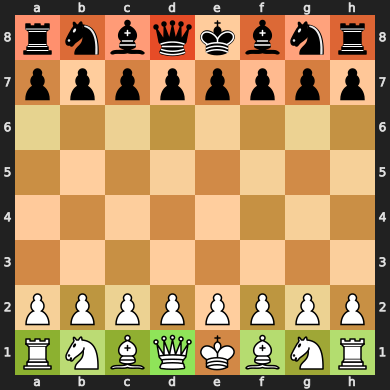

In [158]:
feature_weights = explainer.as_list()
dibujar_tablero_con_mapa(fen, feature_weights)

## SHAP

In [ ]:
fen = '1k6/8/8/8/8/8/7P/1K6 w - - 0 1'
board = chess.Board(fen)
tokenized_boards = get_sequences_from_board(board)
moves = engine.get_ordered_legal_moves(board)

background =  np.array([
                        [29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
 30, 30,  1, 30, 30, 24,  0]] # Turno de blancas
                       )

explainer = shap.KernelExplainer(predict_fn_xai, background, algorithm="partition")  # o kernel
i=0
shap_values = {}

for tokenized_board, move in zip(tokenized_boards, moves):
    print(tokenized_board.shape)
    shap_values[move] = explainer(tokenized_board.reshape(1,-1))
    i=i+1

In [ ]:
for key, value in shap_values.items():
    value.feature_names = pos_labels
    print(f'Importancia SHAP para el movimiento {key}')
    shap.plots.bar(value,max_display=10)
    feature_weights = [(f"{k}=", v) for k, v in zip(value.feature_names, value.values[0])]
    dibujar_tablero_con_mapa(fen, feature_weights, alpha_mult=3)

In [ ]:
print(shap_values.keys)
print(moves)

In [27]:
def apply_shap_to_fen(fen :str, move:str):
    """
    Apply SHAP to a FEN string.
    fen: str
    returns: shap_values: np.array of shape (n_samples, 1)
    """
    board = chess.Board(fen)
    legal_moves = engine.get_ordered_legal_moves(board)
    move_index = np.where([move == x.uci() for x in legal_moves])[0][0]
    print('move_index:', move_index)
    tokenized_board = get_sequences_from_board(board)
    turn = 29 if board.turn == chess.WHITE else 11
    # Tablero vacío para background
    background = [turn, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
 30, 30,  1, 30, 30, 24,  0]

    explainer = shap.Explainer(predict_fn_xai, background, algorithm="partition")  # o kernel
    shap_values = explainer(tokenized_board[move_index]) #.reshape(1, -1))
    return shap_values

# Experimentos

In [35]:
_, return_buckets_values = utils.get_uniform_buckets_edges_values(
    num_return_buckets
)

def experimento_xai(fen, max_moves=5, plot_raw_att=False, plot_board_att_by_rows = True, 
                    plot_board_att_by_cols=True, plot_token_imp=True,
                    plot_attention_rollout=True, plot_attention_flow=False,
                    plot_shap=True, plot_lime=True,
                    save_path=None
                    ):
    
    # Creamos el tablero
    board = chess.Board(fen)
    # Obtenemos los pares tablero-jugada tokenizados
    sequences = get_sequences_from_board(board)
    # Predecimos los logits y mapas de atención
    results = predict_fn(sequences)
    logits = np.array([log[:,-1,:] for log, att in results])
    attention_maps = [att for log, att in results]
    attention_maps = np.array(attention_maps).reshape(-1, num_layers, num_heads, 79, 79)
    
    # Calculamos las probabilidades de victoria de cada jugada
    sorted_legal_moves = engine.get_ordered_legal_moves(board)
    win_probs = np.inner(np.exp(logits), return_buckets_values)
    win_probs = win_probs.flatten()
    
    # Reorganizar el diccionario
    reorganized_dict = {
        move.uci(): {
            "logits": logit.tolist() if isinstance(logit, np.ndarray) else logit,
            "win_probs": win_prob.tolist() if isinstance(win_prob, np.ndarray) else win_prob
        }
        for move, logit, win_prob in zip(sorted_legal_moves, logits, win_probs)
    }

    # Guardar en archivo JSON
    os.makedirs(save_path, exist_ok=True)
    with open(f'{save_path}/results.json', 'w') as f:
        json.dump(reorganized_dict, f, indent=2)
    
    if max_moves == None or max_moves > len(sorted_legal_moves):
        max_moves = len(sorted_legal_moves)
    
    # Creamos los explicadores que nos hagan falta
    if plot_shap:
        turn = 29 if board.turn == chess.WHITE else 11
        # Tablero vacío para background
        background = [turn, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
                        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
                        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  0,
                        30, 30,  1, 30, 30, 24,  0]
        background = np.array(background).reshape(1, -1)
        shap_explainer = shap.KernelExplainer(predict_fn_xai, background, algorithm="partition")  # o kernel
            
   
    # Ejecutamos los experimentos de xAI con las max_moves mejores jugadas
    for i in np.argsort(win_probs)[:-max_moves-1:-1]:
        print(f'  {sorted_legal_moves[i].uci()} -> {100*win_probs[i]:.1f}%')
        # Mapa de atención plano
        if plot_raw_att:
            os.makedirs(f'{save_path}/attention/79x79', exist_ok=True)
            plot_attention_maps(attention_maps[i], token_labels=token_labels, 
                                save_path=f'{save_path}/attention/79x79/_{sorted_legal_moves[i].uci()}.png')
            
        # Mapa de atención en el tablero
        if plot_board_att_by_rows:
            os.makedirs(f'{save_path}/attention/reordered_by_row', exist_ok=True)
            plot_all_attention_heads(attention_maps[i], token_labels=token_labels, by_row=True,
                                    save_path=f'{save_path}/attention/reordered_by_row/{sorted_legal_moves[i].uci()}.png')
            
        # Mapa de atención en el tablero (traspuesto)
        if plot_board_att_by_cols:
            os.makedirs(f'{save_path}/attention/reordered_by_col', exist_ok=True)
            plot_all_attention_heads(attention_maps[i], token_labels=token_labels, by_row=False,
                                save_path=f'{save_path}/attention/reordered_by_col/{sorted_legal_moves[i].uci()}.png')
        
        # Attention rollout
        if plot_attention_rollout:
            os.makedirs(f'{save_path}/attention/attention_rollout', exist_ok=True)
            attention_rollout_maps = attention_rollout(attention_maps[i], alpha=0.5)
            plot_all_attention_heads(attention_rollout_maps.reshape(1,-1,79,79), token_labels=token_labels, scale_in_1=False,
                                     save_path=f'{save_path}/attention/attention_rollout/{sorted_legal_moves[i].uci()}.png')
        
        # Attention flow
        if plot_attention_flow:
            os.makedirs(f'{save_path}/attention/attention_flow', exist_ok=True)
            attention_flow_vals = np.zeros((79,))
            for j in range(79):
                attention_flow_vals[j] = compute_attention_flow(attention_maps[i], sink_token=j)
            plot_attention_flow_heatmap(attention_flow_vals, token_labels=token_labels,
                                        save_path=f'{save_path}/attention/attention_flow/{sorted_legal_moves[i].uci()}.png')
            
        # Importancia de los tokens
        if plot_token_imp:
            os.makedirs(f'{save_path}/token_importances/bars', exist_ok=True)
            os.makedirs(f'{save_path}/token_importances/board', exist_ok=True)
            grads, jacs = compute_token_grad_importance(
                predictor,
                params,   
                sequences[i], 
                predictor_config
            )
            bar_plot_token_importances(grads, token_labels, save_path=f'{save_path}/token_importances/bars/{sorted_legal_moves[i].uci()}_grad.png')
            bar_plot_token_importances(jacs, token_labels, save_path=f'{save_path}/token_importances/bars/{sorted_legal_moves[i].uci()}_jac.png')
            board_plot_token_importances(grads, token_labels, save_path=f'{save_path}/token_importances/board/{sorted_legal_moves[i].uci()}_grad.png')
            board_plot_token_importances(jacs, token_labels, save_path=f'{save_path}/token_importances/board/{sorted_legal_moves[i].uci()}_jac.png')
        
        # SHAP
        if plot_shap:
            os.makedirs(f'{save_path}/shap', exist_ok=True)

            shap_values = shap_explainer(sequences[i].reshape(1,-1))
            feature_weights = [(f"{k}=0", v) for k, v in zip(pos_labels, shap_values.values[0])]
            dibujar_tablero_con_mapa(fen, feature_weights, alpha_mult=3,
                                     save_path=f'{save_path}/shap/{sorted_legal_moves[i].uci()}.svg')
            
        if plot_lime:
            os.makedirs(f'{save_path}/lime/', exist_ok=True)
            print('lime')
            print('fen', fen)
            lime_explainer = LimeExplainer(fen, sorted_legal_moves[i])
            feature_weights = lime_explainer.as_list()
            dibujar_tablero_con_mapa(fen, feature_weights, alpha_mult=3,
                                     save_path=f'{save_path}/lime/{sorted_legal_moves[i].uci()}.svg')
            
            
        gc.collect()

## Experimento 1: Primera jugada de blancas

In [36]:
board1 = chess.Board()
fen1 = board1.fen()

In [37]:
experimento_xai(fen1,
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=True,
                plot_lime=False,
                save_path='xai/experiment1_batched')

sequences.shape[0]: 20
sequences.shape[0]: 1
win_probs: (1,)
  e2e4 -> 53.5%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  d2d4 -> 53.1%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  g1f3 -> 52.6%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  c2c4 -> 52.4%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  e2e3 -> 51.6%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)


## Experimento 2: Primera jugada de negras (1. e4)

In [38]:
board2 = chess.Board()
board2.push(chess.Move.from_uci('e2e4'))
fen2 = board2.fen()

In [39]:
experimento_xai(fen2,
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=True,
                plot_lime=False,
                save_path='xai/experiment2_batched')

sequences.shape[0]: 20
sequences.shape[0]: 1
win_probs: (1,)
  c7c5 -> 47.0%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  e7e6 -> 46.3%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  e7e5 -> 46.2%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  d7d5 -> 45.6%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)
  c7c6 -> 44.7%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2122
win_probs: (2122,)


## Experimento 3 - Carrera de peón

In [40]:
board3 = chess.Board('1k6/8/8/8/8/8/7P/1K6 w - - 0 1')
fen3 = board3.fen()

In [41]:
experimento_xai(fen3, 
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=True,
                plot_lime=False,
                save_path='xai/experiment3_batched')

sequences.shape[0]: 7
sequences.shape[0]: 1
win_probs: (1,)
  h2h4 -> 88.1%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 14
win_probs: (14,)
  h2h3 -> 50.4%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 14
win_probs: (14,)
  b1c2 -> 50.1%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 14
win_probs: (14,)
  b1a1 -> 50.1%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 14
win_probs: (14,)
  b1b2 -> 50.1%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 14
win_probs: (14,)


## Experimento 3.2 - Carrera de peón (negras)

In [67]:
board3_b = chess.Board('1k6/8/8/8/8/8/7P/1K6 b - - 0 1')
fen3_b = board3_b.fen()

In [68]:
experimento_xai(fen3_b, 
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=False,
                plot_lime=True,
                save_path='xai/experiment3_batched/black')

sequences.shape[0]: 5
  b8c7 -> 49.7%
lime
fen 1k6/8/8/8/8/8/7P/1K6 b - - 0 1
Total de muestras únicas generadas: 579
sequences.shape[0]: 5000
win_probs: (5000,)
  b8c8 -> 49.7%
lime
fen 1k6/8/8/8/8/8/7P/1K6 b - - 0 1
Total de muestras únicas generadas: 587
sequences.shape[0]: 5000
win_probs: (5000,)
  b8b7 -> 12.3%
lime
fen 1k6/8/8/8/8/8/7P/1K6 b - - 0 1
Total de muestras únicas generadas: 585
sequences.shape[0]: 5000
win_probs: (5000,)
  b8a8 -> 11.2%
lime
fen 1k6/8/8/8/8/8/7P/1K6 b - - 0 1
Total de muestras únicas generadas: 593
sequences.shape[0]: 5000
win_probs: (5000,)
  b8a7 -> 11.0%
lime
fen 1k6/8/8/8/8/8/7P/1K6 b - - 0 1
Total de muestras únicas generadas: 589
sequences.shape[0]: 5000
win_probs: (5000,)


## Experimento 4 - Mates del pasillo

In [42]:
board4 = chess.Board('1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1')
fen4 = board4.fen()

In [43]:
experimento_xai(fen4, 
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=True,
                plot_lime=False,
                save_path='xai/experiment4_batched')

sequences.shape[0]: 19
sequences.shape[0]: 1
win_probs: (1,)
  g2g8 -> 99.6%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2046
win_probs: (2046,)
  a2a4 -> 50.3%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2046
win_probs: (2046,)
  b2b3 -> 50.2%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2046
win_probs: (2046,)
  a2a3 -> 50.2%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2046
win_probs: (2046,)
  g2g1 -> 50.2%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 2046
win_probs: (2046,)


## Experimento 4.2 - Mates del pasillo (negras)

In [ ]:
board4_b = chess.Board('1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1')
fen4 =  board4_b.fen()

In [ ]:
experimento_xai(fen4, 
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=True,
                plot_lime=False,
                save_path='xai/experiment4_batched/black')

## Experimento 5 - CrossMate

In [44]:
board5 = chess.Board('k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1')
fen5 = board5.fen()

In [45]:
experimento_xai(fen5, 
                max_moves=5,
                plot_raw_att=False,
                plot_board_att_by_rows = False, 
                plot_board_att_by_cols=False, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=True,
                plot_lime=False,
                save_path='xai/experiment5_batched')

sequences.shape[0]: 30
sequences.shape[0]: 1
win_probs: (1,)
  e3a7 -> 99.6%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 126
win_probs: (126,)
  e3e8 -> 53.0%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 126
win_probs: (126,)
  e3e4 -> 51.6%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 126
win_probs: (126,)
  e3a3 -> 51.1%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 126
win_probs: (126,)
  b1c2 -> 50.2%


  0%|          | 0/1 [00:00<?, ?it/s]

sequences.shape[0]: 1
win_probs: (1,)
sequences.shape[0]: 126
win_probs: (126,)


## Experimento 5.2 - CrossMate (negras)

In [ ]:
board5_b = chess.Board('k7/6b1/5q2/8/8/4Q3/5B2/1K6 b - - 0 1')
fen5_b = board5_b.fen()

In [ ]:
experimento_xai(fen5_b, 
                max_moves=1,
                plot_raw_att=False,
                plot_board_att_by_rows=True, 
                plot_board_att_by_cols=True, 
                plot_token_imp=False,
                plot_attention_rollout=False,
                plot_attention_flow=False,
                plot_shap=False,
                plot_lime=True,
                save_path='xai/experiment5_batched/black')

## Diferencia de atenciones

### Experimento 1: Alteraciones en Carrera de peón

In [ ]:
board3 = chess.Board('1k6/8/8/8/8/8/7P/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_3 = get_sequences_from_board(board3)
# Predecimos los logits y mapas de atención
results_3 = predict_fn(sequences_3)
logits_3 = np.array([log[:,-1,:] for log, att in results_3])
attention_maps_3 = [att for log, att in results_3]
attention_maps_3 = np.array(attention_maps_3).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_3 = engine.get_ordered_legal_moves(board3)
win_probs_3 = np.inner(np.exp(logits_3), return_buckets_values)
win_probs_3 = win_probs_3.flatten()

In [ ]:
ordered_indices_3 = np.argsort(win_probs_3)[::-1]
for i in ordered_indices_3:
    print(f'  {sorted_legal_moves_3[i].uci()} -> {100*win_probs_3[i]:.1f}%')

#### Diferencia entre jugar h4 (buena) y h3 (mala)

In [ ]:
attention_maps_3_h4 = attention_maps_3[ordered_indices_3[0]]
attention_maps_3_h3 = attention_maps_3[ordered_indices_3[1]]
diff_attention_map_3_h4_h3 = attention_maps_3_h4 - attention_maps_3_h3

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_h3, token_labels, by_row=True, ,
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsh3_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_h3, token_labels, by_row=False,  
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsh3_col.png')

#### Diferencia entre jugar h4 (buena) y Kc2 (mala)

In [ ]:
attention_maps_3_h4 = attention_maps_3[ordered_indices_3[0]]
attention_maps_3_Kc2 = attention_maps_3[ordered_indices_3[2]]
diff_attention_map_3_h4_Kc2 = attention_maps_3_h4 - attention_maps_3_Kc2

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_Kc2, token_labels, by_row=True,  
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsKc3_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_Kc2, token_labels, by_row=False,  
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsKc3_col.png')

#### Diferencia entre jugar h3 (mala) y Kc2 (mala)

In [ ]:
attention_maps_3_h3 = attention_maps_3[ordered_indices_3[1]]
attention_maps_3_Kc2 = attention_maps_3[ordered_indices_3[2]]
diff_attention_map_3_h3_Kc2 = attention_maps_3_h3 - attention_maps_3_Kc2

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h3_Kc2, token_labels, by_row=True,  
                         save_path='xai/experiment3_batched/attention_comparatives/h3vsKc2_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h3_Kc2, token_labels, by_row=False,  
                         save_path='xai/experiment3_batched/attention_comparatives/h3vsKc2_col.png')

#### Tablero Alternativo 1: Mover el peon de h2 a g2

In [ ]:
board3_alt1 = chess.Board('1k6/8/8/8/8/8/6P1/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_3_alt1 = get_sequences_from_board(board3_alt1)
# Predecimos los logits y mapas de atención
results_3_alt1 = predict_fn(sequences_3_alt1)
logits_3_alt1 = np.array([log[:,-1,:] for log, att in results_3_alt1])
attention_maps_3_alt1 = [att for log, att in results_3_alt1]
attention_maps_3_alt1 = np.array(attention_maps_3_alt1).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_3_alt1 = engine.get_ordered_legal_moves(board3_alt1)
win_probs_3_alt1 = np.inner(np.exp(logits_3_alt1), return_buckets_values)
win_probs_3_alt1 = win_probs_3_alt1.flatten()

In [ ]:
ordered_indices_3_alt1 = np.argsort(win_probs_3_alt1)[::-1]
for i in ordered_indices_3_alt1:
    print(f'  {sorted_legal_moves_3_alt1[i].uci()} -> {100*win_probs_3_alt1[i]:.1f}%')

##### Comparativa Kc2

In [ ]:
attention_maps_3_Kc2_alt1 = attention_maps_3_alt1[ordered_indices_3_alt1[0]]
attention_maps_3_Kc2 = attention_maps_3[ordered_indices_3[2]]
diff_attention_map_3_Kc2_Kc2alt1 = attention_maps_3_Kc2 - attention_maps_3_Kc2_alt1

In [ ]:
plot_all_attention_heads(diff_attention_map_3_Kc2_Kc2alt1, token_labels, by_row=True,  
                         save_path='xai/experiment3_batched/attention_comparatives/Kc2vsKc2alt1_row.png')
plot_all_attention_heads(diff_attention_map_3_Kc2_Kc2alt1, token_labels, by_row=False,  
                         save_path='xai/experiment3_batched/attention_comparatives/Kc2vsKc2alt1_col.png')

#### Comparativa avance peones

In [ ]:
attention_maps_3_h4 = attention_maps_3[ordered_indices_3[0]]
attention_maps_3_g4_alt1 = attention_maps_3_alt1[ordered_indices_3_alt1[-1]]
diff_attention_map_3_h4_g4alt1 = attention_maps_3_h4 - attention_maps_3_g4_alt1

In [ ]:
plot_all_attention_heads(diff_attention_map_3_h4_g4alt1, token_labels, by_row=True,  
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsg4alt1_row.png')
plot_all_attention_heads(diff_attention_map_3_h4_g4alt1, token_labels, by_row=False,  
                         save_path='xai/experiment3_batched/attention_comparatives/h4vsg4alt1_col.png')

#### Secuencia de avance del peón

In [ ]:
secuencia_movimientos = ['h2h4', 'b8c7', 'h4h5', 'c7d7', 'h5h6', 'd7e7', 'h6h7', 'e7f7', 'h7h8q']

In [ ]:
board3_avance = board3.copy()
logits_3_avance = []
attention_maps_3_avance = []

for move in secuencia_movimientos:
    
    sequences_3_avance = get_sequences_from_board(board3_avance)
    results_3_avance_i = predict_fn(sequences_3_avance)
    logits_3_avance_i = np.array([log[:,-1,:] for log, att in results_3_avance_i])
    attention_maps_3_avance_i = [att for log, att in results_3_avance_i]
    attention_maps_3_avance_i = np.array(attention_maps_3_avance_i).reshape(-1, num_layers, num_heads, 79, 79)
    
    logits_3_avance.append(logits_3_avance_i)
    attention_maps_3_avance.append(attention_maps_3_avance_i[engine.get_ordered_legal_moves(board3_avance)
                                                                 .index(chess.Move.from_uci(move))])
    
    board3_avance.push(chess.Move.from_uci(move))
    print(board3_avance.fen())

In [ ]:
for move, logits, attention_maps in zip(secuencia_movimientos, logits_3_avance, attention_maps_3_avance):
    print(f'Movimiento: {move}')
    print('Logits shape:', logits.shape)
    print('Attention maps shape:', attention_maps.shape)
    
    plot_all_attention_heads(attention_maps, token_labels, by_row=True, 
                             save_path=f'xai/experiment3_batched/secuencia_avance/attention/reordered_by_row/{move}.png')
    
    plot_all_attention_heads(attention_maps, token_labels, by_row=False, 
                             save_path=f'xai/experiment3_batched/secuencia_avance/attention/reordered_by_col/{move}.png')

### Experimento 2: Alteraciones en Mates del Pasillo

In [ ]:
board4 = chess.Board('1k6/ppp4r/8/8/8/8/PPP3R1/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_4 = get_sequences_from_board(board4)
# Predecimos los logits y mapas de atención
results_4 = predict_fn(sequences_4)
logits_4 = np.array([log[:,-1,:] for log, att in results_4])
attention_maps_4 = [att for log, att in results_4]
attention_maps_4 = np.array(attention_maps_4).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_4 = engine.get_ordered_legal_moves(board4)
win_probs_4 = np.inner(np.exp(logits_4), return_buckets_values)
win_probs_4 = win_probs_4.flatten()

In [ ]:
ordered_indices_4 = np.argsort(win_probs_4)[::-1]
for i in ordered_indices_4:
    print(f'  {sorted_legal_moves_4[i].uci()} -> {100*win_probs_4[i]:.1f}%')

#### Diferencia entre mejor jugada (Rg8#) y segunda mejor (a4 - empate)

In [ ]:
attention_maps_4_Rg8 = attention_maps_4[ordered_indices_4[0]]
attention_maps_4_a4 = attention_maps_4[ordered_indices_4[1]]
diff_attention_map_4_Rg8_a4 = attention_maps_4_Rg8 - attention_maps_4_a4

In [ ]:
os.makedirs('xai/experiment4_batched/attention_comparatives', exist_ok=True)

In [ ]:
plot_all_attention_heads(diff_attention_map_4_Rg8_a4, token_labels, by_row=True, 
                         save_path='xai/experiment4_batched/attention_comparatives/Rg8_a4_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_4_Rg8_a4, token_labels, by_row=False, 
                         save_path='xai/experiment4_batched/attention_comparatives/Rg8_a4_col.png')

#### Diferencia entre turno de blancas y negras

In [ ]:
board4_b = chess.Board('1k6/ppp4r/8/8/8/8/PPP3R1/1K6 b - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_4_b = get_sequences_from_board(board4_b)
# Predecimos los logits y mapas de atención
results_4_b = predict_fn(sequences_4_b)
logits_4_b = np.array([log[:,-1,:] for log, att in results_4_b])
attention_maps_4_b = [att for log, att in results_4_b]
attention_maps_4_b = np.array(attention_maps_4_b).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_4_b = engine.get_ordered_legal_moves(board4_b)
win_probs_4_b = np.inner(np.exp(logits_4_b), return_buckets_values)
win_probs_4_b = win_probs_4_b.flatten()

In [ ]:
ordered_indices_4_b = np.argsort(win_probs_4_b)[::-1]
for i in ordered_indices_4_b:
    print(f'  {sorted_legal_moves_4_b[i].uci()} -> {100*win_probs_4_b[i]:.1f}%')

In [ ]:
attention_maps_4_Rg8 = attention_maps_4[ordered_indices_4[0]]
attention_maps_4_b_Rh1 = attention_maps_4_b[ordered_indices_4_b[0]]
diff_attention_map_4_Rg8_b_Rh1 = attention_maps_4_Rg8 - attention_maps_4_b_Rh1

In [ ]:
os.makedirs('xai/experiment4_batched/attention_comparatives', exist_ok=True)
os.makedirs('xai/experiment4_batched/black', exist_ok=True)

In [ ]:
plot_all_attention_heads(diff_attention_map_4_Rg8_b_Rh1, token_labels, by_row=True,  
                         save_path='xai/experiment4_batched/attention_comparatives/turnwhite_vs_turnblack_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_4_Rg8_b_Rh1, token_labels, by_row=False,  
                         save_path='xai/experiment4_batched/attention_comparatives/turnwhite_vs_turnblack_col.png')

#### Cambio de la torre negra por un alfil

In [ ]:
board4_alt = chess.Board('1k6/ppp4b/8/8/8/8/PPP3R1/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_4_alt = get_sequences_from_board(board4_alt)
# Predecimos los logits y mapas de atención
results_4_alt = predict_fn(sequences_4_alt)
logits_4_alt = np.array([log[:,-1,:] for log, att in results_4_alt])
attention_maps_4_alt = [att for log, att in results_4_alt]
attention_maps_4_alt = np.array(attention_maps_4_alt).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_4_alt = engine.get_ordered_legal_moves(board4_alt)
win_probs_4_alt = np.inner(np.exp(logits_4_alt), return_buckets_values)
win_probs_4_alt = win_probs_4_alt.flatten()

In [ ]:
ordered_indices_4_alt = np.argsort(win_probs_4_alt)[::-1]
for i in ordered_indices_4_alt:
    print(f'  {sorted_legal_moves_4_alt[i].uci()} -> {100*win_probs_4_alt[i]:.1f}%')

In [ ]:
board4_alt

In [ ]:
sorted_legal_moves_4

In [ ]:
ordered_indices_4_alt

In [ ]:
idx_Rg8 = sorted_legal_moves_4.index(chess.Move.from_uci('g2g8'))
idx_Rg8_alt1 = sorted_legal_moves_4_alt.index(chess.Move.from_uci('g2g8'))

attention_maps_4_Rg8 = attention_maps_4[idx_Rg8]
attention_maps_4_alt_Rg8 = attention_maps_4_alt[idx_Rg8_alt1]
diff_attention_map_Rg8_alt_Rg8 = attention_maps_4_Rg8 - attention_maps_4_alt_Rg8

In [ ]:
os.makedirs('xai/experiment4_batched/attention_comparatives', exist_ok=True)
os.makedirs('xai/experiment4_batched/bishop', exist_ok=True)

In [ ]:
plot_all_attention_heads(attention_maps_4_alt_Rg8, token_labels, by_row=True,  
                         save_path='xai/experiment4_batched/bishop/g2g8_row.png')

In [ ]:
plot_all_attention_heads(attention_maps_4_alt_Rg8, token_labels, by_row=False,  
                         save_path='xai/experiment4_batched/bishop/g2g8_col.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_Rg8_alt_Rg8, token_labels, by_row=True,  
                         save_path='xai/experiment4_batched/attention_comparatives/g2g8R_vs_g2g8b_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_Rg8_alt_Rg8, token_labels, by_row=False,  
                         save_path='xai/experiment4_batched/attention_comparatives/g2g8R_vs_g2g8b_col.png')

### Experimento 3: Alteraciones en CrossMate

In [ ]:
board5 = chess.Board('k7/6b1/5q2/8/8/4Q3/5B2/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_5 = get_sequences_from_board(board5)
# Predecimos los logits y mapas de atención
results_5 = predict_fn(sequences_5)
logits_5 = np.array([log[:,-1,:] for log, att in results_5])
attention_maps_5 = [att for log, att in results_5]
attention_maps_5 = np.array(attention_maps_5).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_5 = engine.get_ordered_legal_moves(board5)
win_probs_5 = np.inner(np.exp(logits_5), return_buckets_values)
win_probs_5 = win_probs_5.flatten()

In [ ]:
ordered_indices_5 = np.argsort(win_probs_5)[::-1]
for i in ordered_indices_5:
    print(f'  {sorted_legal_moves_5[i].uci()} -> {100*win_probs_5[i]:.1f}%')

#### Alteración 1: Cambio de turno

In [ ]:
board5_b = chess.Board('k7/6b1/5q2/8/8/4Q3/5B2/1K6 b - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_5_b = get_sequences_from_board(board5_b)
# Predecimos los logits y mapas de atención
results_5_b = predict_fn(sequences_5_b)
logits_5_b = np.array([log[:,-1,:] for log, att in results_5_b])
attention_maps_5_b = [att for log, att in results_5_b]
attention_maps_5_b = np.array(attention_maps_5_b).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_5_b = engine.get_ordered_legal_moves(board5_b)
win_probs_5_b = np.inner(np.exp(logits_5_b), return_buckets_values)
win_probs_5_b = win_probs_5_b.flatten()

In [ ]:
ordered_indices_5_b = np.argsort(win_probs_5_b)[::-1]
for i in ordered_indices_5_b:
    print(f'  {sorted_legal_moves_5_b[i].uci()} -> {100*win_probs_5_b[i]:.1f}%')

In [ ]:
attention_maps_5_Qa7 = attention_maps_5[ordered_indices_5[0]]
attention_maps_5_b_Qb2 = attention_maps_5_b[ordered_indices_5_b[0]]
diff_attention_map_5_Qa7_b_Qb2 = attention_maps_5_Qa7 - attention_maps_5_b_Qb2

In [ ]:
os.makedirs('xai/experiment5_batched/attention_comparatives', exist_ok=True)

In [ ]:
plot_all_attention_heads(diff_attention_map_5_Qa7_b_Qb2, token_labels, by_row=True,  
                         save_path='xai/experiment5_batched/attention_comparatives/whiteturn_vs_blackturn_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_5_Qa7_b_Qb2, token_labels, by_row=False,  
                         save_path='xai/experiment5_batched/attention_comparatives/whiteturn_vs_blackturn_col.png')

#### Alteración 2: Borrado de alfil

In [ ]:
board5_alt1 = chess.Board('k7/6b1/5q2/8/8/4Q3/8/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_5_alt1 = get_sequences_from_board(board5_alt1)
# Predecimos los logits y mapas de atención
results_5_alt1 = predict_fn(sequences_5_alt1)
logits_5_alt1 = np.array([log[:,-1,:] for log, att in results_5_alt1])
attention_maps_5_alt1 = [att for log, att in results_5_alt1]
attention_maps_5_alt1 = np.array(attention_maps_5_alt1).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_5_alt1 = engine.get_ordered_legal_moves(board5_alt1)
win_probs_5_alt1 = np.inner(np.exp(logits_5_alt1), return_buckets_values)
win_probs_5_alt1 = win_probs_5_alt1.flatten()

In [ ]:
ordered_indices_5_alt1 = np.argsort(win_probs_5_alt1)[::-1]
for i in ordered_indices_5_alt1:
    print(f'  {sorted_legal_moves_5_alt1[i].uci()} -> {100*win_probs_5_alt1[i]:.1f}%')

In [ ]:
board5_alt1

In [ ]:
# Buscamos la jugada Qa7 en el tablero original y en el alternativo
idx_Qa7 = sorted_legal_moves_5.index(chess.Move.from_uci('e3a7'))
idx_Qa7_alt1 = sorted_legal_moves_5_alt1.index(chess.Move.from_uci('e3a7'))

attention_maps_5_Qa7 = attention_maps_5[idx_Qa7]
attention_maps_5_alt1_Qa7 = attention_maps_5_alt1[idx_Qa7_alt1]
diff_attention_map_5_Qa7_alt1_Qa7 = attention_maps_5_Qa7 - attention_maps_5_alt1_Qa7

In [ ]:
os.makedirs('xai/experiment5_batched/attention_comparatives', exist_ok=True)
os.makedirs('xai/experiment5_batched/nobishop', exist_ok=True)

In [ ]:
plot_all_attention_heads(attention_maps_5_alt1_Qa7, token_labels, by_row=True,  
                         save_path='xai/experiment5_batched/nobishop/Qa7nobishop_row.png')

In [ ]:
plot_all_attention_heads(attention_maps_5_alt1_Qa7, token_labels, by_row=False,  
                         save_path='xai/experiment5_batched/nobishop/Qa7nobishop_col.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_5_Qa7_alt1_Qa7, token_labels, by_row=True,  
                         save_path='xai/experiment5_batched/attention_comparatives/Qa7_vs_Qa7nobishop_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_5_Qa7_alt1_Qa7, token_labels, by_row=False,  
                         save_path='xai/experiment5_batched/attention_comparatives/Qa7_vs_Qa7nobishop_col.png')

#### Alteración 3: Cambio de alfil por caballo coordinante

In [ ]:
board5_alt2 = chess.Board('k7/6b1/2N2q2/8/8/4Q3/8/1K6 w - - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_5_alt2 = get_sequences_from_board(board5_alt2)
# Predecimos los logits y mapas de atención
results_5_alt2 = predict_fn(sequences_5_alt2)
logits_5_alt2 = np.array([log[:,-1,:] for log, att in results_5_alt2])
attention_maps_5_alt2 = [att for log, att in results_5_alt2]
attention_maps_5_alt2 = np.array(attention_maps_5_alt2).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_5_alt2 = engine.get_ordered_legal_moves(board5_alt2)
win_probs_5_alt2 = np.inner(np.exp(logits_5_alt2), return_buckets_values)
win_probs_5_alt2 = win_probs_5_alt2.flatten()

In [ ]:
ordered_indices_5_alt2 = np.argsort(win_probs_5_alt2)[::-1]
for i in ordered_indices_5_alt2:
    print(f'  {sorted_legal_moves_5_alt2[i].uci()} -> {100*win_probs_5_alt2[i]:.1f}%')

In [ ]:
board5_alt2

In [ ]:
# Buscamos la jugada Qa7 en el tablero original y en el alternativo
idx_Qa7 = sorted_legal_moves_5.index(chess.Move.from_uci('e3a7'))
idx_Qa7_alt2 = sorted_legal_moves_5_alt2.index(chess.Move.from_uci('e3a7'))

attention_maps_5_Qa7 = attention_maps_5[idx_Qa7]
attention_maps_5_alt2_Qa7 = attention_maps_5_alt2[idx_Qa7_alt2]
diff_attention_map_5_Qa7_alt2_Qa7 = attention_maps_5_Qa7 - attention_maps_5_alt2_Qa7

In [ ]:
os.makedirs('xai/experiment5_batched/attention_comparatives', exist_ok=True)
os.makedirs('xai/experiment5_batched/knight', exist_ok=True)

In [ ]:
plot_all_attention_heads(attention_maps_5_alt2_Qa7, token_labels, by_row=True,  
                         save_path='xai/experiment5_batched/knight/Qa7knight_row.png')

In [ ]:
plot_all_attention_heads(attention_maps_5_alt2_Qa7, token_labels, by_row=False,  
                         save_path='xai/experiment5_batched/knight/Qa7knight_col.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_5_Qa7_alt2_Qa7, token_labels, by_row=True,  
                         save_path='xai/experiment5_batched/attention_comparatives/Qa7_vs_Qa7knight_row.png')

In [ ]:
plot_all_attention_heads(diff_attention_map_5_Qa7_alt2_Qa7, token_labels, by_row=False,  
                         save_path='xai/experiment5_batched/attention_comparatives/Qa7_vs_Qa7knight_col.png')

In [ ]:
board3 = chess.Board('rnbqkbnr/pppppppp/8/8/8/R7/PPPPPPPP/1NBQKBNR w KQkq - 0 1')
# Obtenemos los pares tablero-jugada tokenizados
sequences_3 = get_sequences_from_board(board3)
# Predecimos los logits y mapas de atención
results_3 = predict_fn(sequences_3)
logits_3 = np.array([log[:,-1,:] for log, att in results_3])
attention_maps_3 = [att for log, att in results_3]
attention_maps_3 = np.array(attention_maps_3).reshape(-1, num_layers, num_heads, 79, 79)
# Calculamos las probabilidades de victoria de cada jugada
sorted_legal_moves_3 = engine.get_ordered_legal_moves(board3)
win_probs_3 = np.inner(np.exp(logits_3), return_buckets_values)
win_probs_3 = win_probs_3.flatten()

In [ ]:
ordered_indices_3 = np.argsort(win_probs_3)[::-1]
for i in ordered_indices_3:
    print(f'  {sorted_legal_moves_3[i].uci()} -> {100*win_probs_3[i]:.1f}%')